<img src="images/keepcoding.png" width=200 align="left">

# Módulo de Matemáticas 101: práctica

Vamos a poner de nuevo en práctica lo que hemos visto en este módulo. La práctica se centra en la regresión lineal (¡tema muy importante!) y podéis preguntarme las dudas que tengáis por Discord. ¡Mucha suerte!

<img src="./images/luck.gif" alt="Drawing" style="width: 300px;"/>

## 1. Regresión lineal con mínimos cuadrados

En este ejercicio vamos a implementar la forma matricial de la regresión lineal con el método de los mínimos cuadrados. Para ello, tendrás que:

- Explorar un dataset
- Implementar la regresión lineal
- Aplicarla a los datos

Como recordatorio, los valores de los pesos $\widehat{w}$ vienen dados por:

<center>$\widehat{w} = (X^T X)^{-1}X^T y,$</center>

Donde $y$ es la variable a predecir y $X$ la matriz de features (NOTA: revisa cómo se define en los apuntes). Sabemos que los pesos van a ser los parámetros de la ecuación lineal que estamos intentando ajustar y tendremos uno por cada variable de entrada que usemos y además un término independiente o bias.

### 1.1 Carga del dataset y exploración de datos

Vamos a usar el dataset de [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) que podemos encontrar en el [repositorio de Machine learning de UC Irvine](https://archive.ics.uci.edu/). Lo primero, vamos a familiarizarnos con los datos.

En el propio repositorio nos indican cómo descargar el dataset con su librería (podemos consultar el código fuente si queremos).

In [37]:
!pip install ucimlrepo



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# metadata  
# variable information 
print(auto_mpg.variables) 


           name     role         type demographic description units  \
0  displacement  Feature   Continuous        None        None  None   
1           mpg   Target   Continuous        None        None  None   
2     cylinders  Feature      Integer        None        None  None   
3    horsepower  Feature   Continuous        None        None  None   
4        weight  Feature   Continuous        None        None  None   
5  acceleration  Feature   Continuous        None        None  None   
6    model_year  Feature      Integer        None        None  None   
7        origin  Feature      Integer        None        None  None   
8      car_name       ID  Categorical        None        None  None   

  missing_values  
0             no  
1             no  
2             no  
3            yes  
4             no  
5             no  
6             no  
7             no  
8             no  


Con la función `head` de Pandas podemos ver las primeras filas del dataset.

In [2]:
X.head()


,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [3]:
y.head()


,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


In [4]:
auto_mpg.variables.name

0    displacement
1             mpg
2       cylinders
3      horsepower
4          weight
5    acceleration
6      model_year
7          origin
8        car_name
Name: name, dtype: object

In [5]:
print(f'el tipo de y es: {type(y)}')
print(f'el shape de y es: {y.shape}')

print(f'El tipo de X es: {type(X)}')
print(f'El shape de X es: {X.shape}')

el tipo de y es: <class 'pandas.core.frame.DataFrame'>
el shape de y es: (398, 1)
El tipo de X es: <class 'pandas.core.frame.DataFrame'>
El shape de X es: (398, 7)


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def visualiza(df,y, nombre_columna= "weight"):
    """
    Dibuja un gráfico de dispersión basado en la columna especificada por el usuario.
    
    Parámetros:
    df : DataFrame - El DataFrame que contiene los features.
    y : DataFrame - El DataFrame que contiene los valores target de la variable dependiente (consumo millas por galon) .
    nombre_columna : str - El nombre de la columna a visualizar (por defecto es "weight").
    """
    
    """
    #El método .loc permite seleccionar datos utilizando etiquetas en lugar de posiciones enteras. El output es una serie
    X_selected = df.loc[:,nombre_columna]

    #Si hago esto después tengo que transformar la serie de nuevo en un dataframe
    df_X_selected = X_selected.to_frame()
    
    print(df_X_selected
    """
    
    #Selecciono de mi dataframe inicial la característica que introduzca el usuario. Esto no convierte el datframe en una serie.
    df_X_selected = df[[nombre_columna]]

    #defino la gráfica de dispersión
    plt.scatter(df_X_selected,y, color="red", s=5)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel(nombre_columna)
    plt.ylabel("consumo:millas x galón")
    plt.title(f"Gráfico de dispersión de {nombre_columna}")
    plt.show()



Crea una función a la que le pases los dataframes de features y de target y el nombre de la variable y haga la gráfica del target (consumo en galones por milla) vs la variable que le ha llegado por parámetro. Puedes ver un ejemplo de gráfica más abajo.

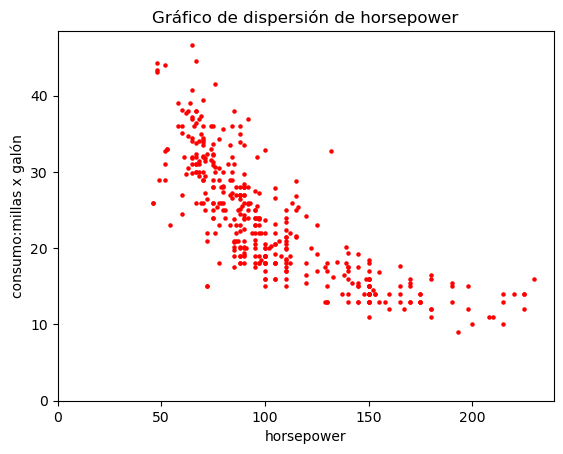

In [7]:
visualiza(X, y, 'horsepower')



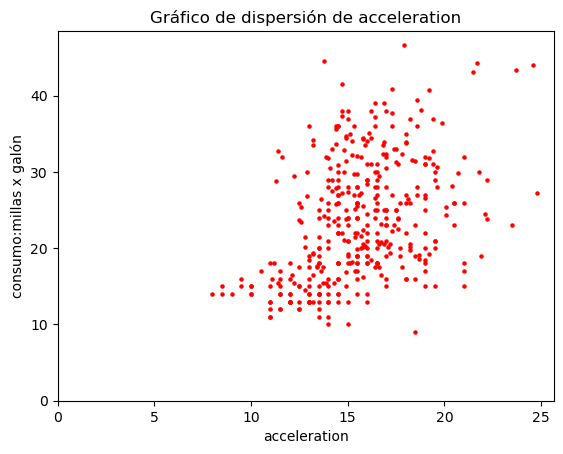

In [8]:
visualiza(X, y, 'acceleration')

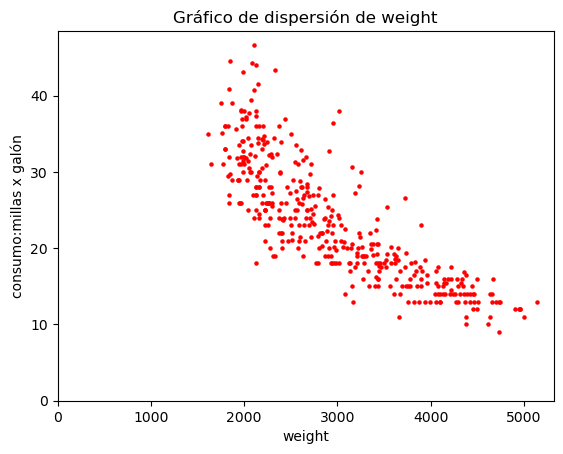

In [9]:
visualiza(X, y, 'weight')

Aunque lo ideal sería un modelo multivariante, vamos a elegir la variable `weight` y hacer una regresión lineal solo con esta variable.

### 1.2 Implementación del modelo

Lo primero, implementa una función que devuelva los valores de $\widehat{w}$ dados X e y. Si se da el caso de que el dataset tiene más features que observaciones, queremos transponerlo antes de realizar las operaciones. Lo hacemos porque, como vimos en clase, los resultados no van a ser buenos si el número de observaciones es menor.

In [10]:
import numpy as np
def pesos_ols(X, y):
    # Implementa la fórmula matricial 𝑤ˆ=(𝑋𝑇𝑋)−1𝑋𝑇𝑦,
    # TODO 1 Comprueba que las dimensiones son adecuadas y corrige si no es así
    """
    #El método .loc permite seleccionar datos utilizando etiquetas en lugar de posiciones enteras. El output es una serie
    X_selected = X.loc[:,"weight"]
    #Transformo la serie en un dataframe. Este dataframe es mi matriz de características en la que cada
    #Cada fila representa un conjunto de observaciones (n)
    #Cada columna representa la característica "weight" (d)
    df_X_selected = X_selected.to_frame()
    
    """
      
    df_X_selected = X[["weight"]]
    
    # TODO 2 Prepara la matriz X para que tenga la forma adecuada para aplicar la fórmula 
    ones = np.ones((398,1))
    X_b = np.concatenate((ones, df_X_selected), axis = 1)
    X_bt = np.transpose(X_b)
    X_btXb = np.dot(X_bt,X_b)
    X_btXb_inv = np.linalg.inv(X_btXb)
    w = np.dot(X_btXb_inv, np.dot(X_bt,y))
    
    #return print(X_b.shape, X_bt.shape, X_btXb.shape,X_btXb_inv.shape, y.shape, w.shape, w)
    return w
    # TODO 3 Calcula los pesos
w = pesos_ols(X,y)
w.shape
    


(2, 1)

In [11]:
"""
Comprobación empleando la de Numpy directamente
"""
X_selected = X.loc[:,"weight"]
df_X_selected = X_selected.to_frame()
ones = np.ones((398,1))
X_b = np.concatenate((ones, df_X_selected), axis = 1)
w_fast, _, _, _ = np.linalg.lstsq(X_b, y, rcond = None)
w_fast

array([[ 4.63173644e+01],
       [-7.67661006e-03]])

### 1.3 Prueba del modelo en los datos de consumo de coches

Ya podemos usar nuestra función `pesos` en el dataset real que hemos descargado. Para ver el ajuste, dibuja de nuevo los datos junto con la recta que has obtenido, en la misma gráfica. Tendrás que convertir los dataframes de Pandas en arrays de numpy para poder aplicar las operaciones matriciales.

TIP: Revisa las dimensiones de todos los arrays para ver que son correctas.

'\n\n# Aplica el modelo y dibuja la recta junto con los datos\nprint(w.shape)\nprint(w)\ndf_X_selected = X[["weight"]]\nX_b = np.c_[np.ones((X.shape[0], 1)), df_X_selected]\nprint(X_b.shape)\nrecta = np.dot(X_b, w)\nplt.plot(df_X_selected, recta, color="blue", label="Recta estimada")\nplt.scatter(df_X_selected,y, color="red", s=5)\n# Forzar que los ejes empiecen en 0\nplt.xlim(left=0)\nplt.ylim(bottom=0)\n\nplt.xlabel("weight")\nplt.ylabel("consumo:millas x galón")\nplt.title("Gráfico de regresión lineal ")\nplt.show()\n\n'

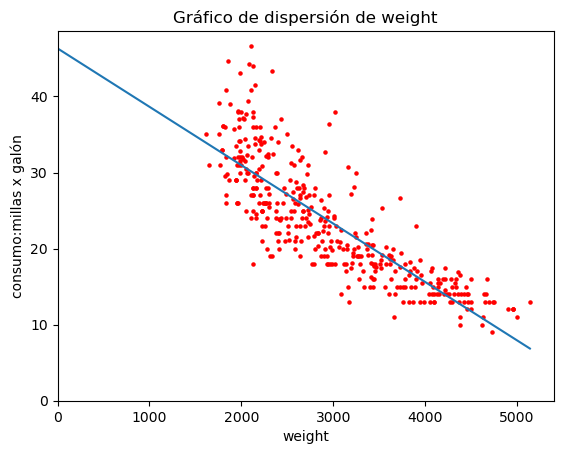

El intercepto es:  [46.31736442]
La pendiente de la recta es:  [-0.00767661]


In [13]:
# Aplica el modelo y dibuja la recta junto con los datos

#   creo los valores desde 0 hasta el máximo de X con la columna weight
#   X[["weight"]] devuelve un DataFrame, y max aplicado directamente a un
#   DataFrame no funciona. hay convertir a una serie o tomar el valor de la columna antes de aplicar max



valoresX_recta = np.linspace(0, max(X["weight"]), 100)
# Creo la variable dependiente "recta" en función de los valores de X creados anteriormente
recta = w[0] + (w[1]*valoresX_recta)

#Creo los gráficos de puntos y recta
plt.plot(valoresX_recta,recta)
visualiza(X,y)
print(f'El intercepto es: ', w[0])
print(f'La pendiente de la recta es: ', w[1])

Por último, vamos a comprar el resultado con el que nos da `scikit-learn`para ver si nuestra implementación tiene buena pinta. Podemos ver cómo funciona en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [15]:
from sklearn.linear_model import LinearRegression

# Creamos el objeto
lr = LinearRegression()

# Le pasamos los datos en el formato correcto
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

X_lr = X[['weight']]
y_lr = y

# Entrenamos con los datos
lr.fit(X_lr,y_lr)
print("Punto de corte:", lr.intercept_)
print("Pendiente:", lr.coef_)



Punto de corte: [46.31736442]
Pendiente: [[-0.00767661]]


**TODO**: Analiza el resultado obtenido y compáralo con el de sklearn

### 1.4 Compara el método de mínimos cuadrados y el descenso del gradiente para obtener los coeficientes de una regresión lineal



## 2. Optimización con descenso del gradiente [OPCIONAL]

Este ejercicio es opcional, no es necesario hacerlo para conseguir el APTO en la práctica, pero podéis hacerlo si queréis practicar más sobre el método del descenso del gradiente, que es muy importante en machine learning.

Vamos a resolver el mismo problema usando el descenso del gradiente en lugar de la solución analítica. El descenso del gradiente es un método de optimización iterativo que usa el operador gradiente.

Como es iterativo, necesitamos decirle cuándo tiene que parar y darnos la solución. En este caso, le vamos a decir que pare y nos devuelva la solución después de un número de iteraciones que le pasaremos como parámetro. La ecuación iterativa es.

$$w^{t+1} = w^t - \eta \cdot \nabla f(w)$$

donde f es nuestra función objetivo, y w es un vector. Para la función objetivo, vamos a usar el error RSS, que querremos minimizar.

$$ RSS(w) = \frac{1}{2}\sum_{n=1}^{N}[y_n-f(x_n)]^2$$

y cuyo gradiente es:

$$\nabla RSS(w) = X^T(Xw^t-y)$$

TIP: Ten en cuenta que el RSS también lo puedes escribir como $\frac{1}{2}\sum_{n=1}^{N}[y_n-\hat{y_n}]^2$ donde $\hat{y_n} = X \hat{w}$ en cada paso.

### 2.1 Implementar el descenso del gradiente

Completa las siguientes funciones para implementar el descenso del gradiente con la función objetivo de la regresión lineal. La función necesitará:

- La entrada X y salida y de la regresión
- Un punto inicial desde el que empezar a iterar
- El número de iteraciones 
- El learning rate

La función nos devolverá un array con las w resultantes de las iteraciones y otro con el valor de la función en cada paso del algoritmo, a la que también se conoce como *loss function*.

In [ ]:
import numpy as np

def gradient_descent(X, y, w0, n_iter, eta): 
    # Define la función que calcule n_iter iteraciones del descenso del gradiente
    # Inicializamos variables
    # Si eliges otra forma de resolverlo, puedes borrar esta parte
    loss_iter = [np.inf]
    w_iter = [w0]
    w = w0
    
    # TODO 1 Añade la columna de 1s
    
    
    # TODO 2 Haz un bucle para las iteraciones 
    # TODO 3 Dentro del bucle tendrás que actualizar el error y los pesos y añadirlos a las listas
    
    
    # Devuelve los resultados
    return np.array(w_iter), np.array(loss_iter)


eta = 0.01 
iteraciones = 2000 

np.random.seed(123)
w0 = np.random.rand(2).reshape((2,1))

y = np.array([208500, 181500, 223500, 140000, 250000]).reshape((5,1))
X = np.array( [[  0.37020659],
               [  -0.48234664],
               [  0.51483616],
               [  0.38352774],
               [  1.29888065]])

weights, loss = gradient_descent(X, y, w0, iteraciones, eta)

print(weights[-1])

### 2.2 Aplicar al dataset de consumo de combustible

Leemos de nuevo los datos y aplicamos la función que acabamos de programar.

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# convert to numpy
X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

print(X_np.shape)
print(y_np.shape)

Para ayudar al algoritmo, vamos a escalar la variable X, restando la media y dividiendo entre la desviación estándar. Después aplicamos la función anterior y dibujamos.

In [ ]:
# TODO Aplica el modelo y dibuja la recta junto con los datos

X = auto_mpg.data.features
y = auto_mpg.data.targets

# Escalamos la variable x 

X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

X_gd=(X_np - X_np.mean()) / X_np.std()
y_gd = y_np

# TODO 1 Punto inicial y learning rate


# TODO 2 Aplicamos el algoritmo


# Límites de los ejes
x_max = np.max(X_gd) + 1
x_min = np.min(X_gd) -1


# TODO 3 Dibuja la gráfica
